Imports

In [3]:
import os
import multiprocessing
#import rasterio
import tensorflow as tf
from glob import glob
import pickle
import numpy as np
import os
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import layers
import keras
import pandas as pd
#import matplotlib.pyplot as plt

In [8]:
tf.__version__

'2.3.0'

Test with Simple CNN and Data Loader 

In [2]:
import boto3
import rasterio as rio
import numpy as np
import io

In [4]:
from data_loader import DataLoader

In [5]:
batch_size = 20
gen = DataLoader(label_file_path_train="labels_test_v1.csv",
                label_file_path_val="val_labels.csv",
                label_mapping_path="labels.json",
                bucket_name='canopy-production-ml',
                data_extension_type='.tif',
                training_data_shape=(100, 100, 18),
                augment=True,
                random_flip_up_down=False, #Randomly flips an image vertically (upside down). With a 1 in 2 chance, outputs the contents of `image` flipped along the first dimension, which is `height`.
                random_flip_left_right=False,
                flip_left_right=False,
                flip_up_down=False,
                rot90=True,
                transpose=False,
                enable_shuffle=False,
                training_data_shuffle_buffer_size=10,
                training_data_batch_size=batch_size,
                training_data_type=tf.float32,
                label_data_type=tf.uint8,
                num_parallel_calls=int(2))
# TODO add data augmentation in DataLoader 

# no_of_val_imgs = len(gen.validation_filenames)
# no_of_train_imgs = len(gen.training_filenames)
# print("Validation on {} images ".format(str(no_of_val_imgs)))
# print("Training on {} images ".format(str(no_of_train_imgs)))

Data augmentation enabled 
Training on 200 images 
Validation on 366 images 
Your training file is missing positive labels for classes ['0', '2', '3', '7', '8', '9']


In [6]:
gen

In [7]:
gen.class_weight

{1: 0.76875, 4: 0.4270833333333333, 5: 10.25, 6: 3.84375}

In [13]:
df["1"]

0     0
1     0
2     0
3     0
4     0
     ..
95    1
96    1
97    1
98    0
99    0
Name: 1, Length: 100, dtype: int64

In [25]:
labels = {}

for column in df.columns:
    
    col_count = df[column].value_counts()
#     print("column:",column)
#     print(col_count)
    
    try:
        col_count = df[column].value_counts()[1]
        labels[column] = col_count
    except:
        print(f"Missing positive chips for class {column}. Class weight ")

Missing positive chips for class 0
Missing positive chips for class 2
Missing positive chips for class 3
Missing positive chips for class 7
Missing positive chips for class 8
Missing positive chips for class 9


In [26]:
labels

{'1': 40, '4': 72, '5': 3, '6': 8, 'paths': 1}

In [6]:
def Simple_CNN(numclasses, input_shape): #TODO use a more complex CNN
        model = Sequential([
            layers.Input(input_shape),
            layers.Conv2D(16, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(32, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(64, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dense(numclasses)
        ])
        return model

model_simpleCNN = Simple_CNN(10, input_shape=(100, 100, 18))
callbacks_list = []

model_simpleCNN.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
          optimizer=keras.optimizers.Adam()) #TODO add callbacks to save checkpoints and maybe lr reducer,etc 

epochs = 10
history = model_simpleCNN.fit(gen.training_dataset, validation_data=gen.validation_dataset, epochs=epochs)


Epoch 1/10
5/5 [==============================] - 86s 18s/step - loss: 8.7035 - val_loss: 1.5012
Epoch 2/10
5/5 [==============================] - 81s 17s/step - loss: 1.4694 - val_loss: 0.8578
Epoch 3/10
5/5 [==============================] - 82s 17s/step - loss: 0.6244 - val_loss: 0.2065
Epoch 4/10
5/5 [==============================] - 86s 17s/step - loss: 0.1674 - val_loss: 0.2439
Epoch 5/10
5/5 [==============================] - 84s 17s/step - loss: 0.1836 - val_loss: 0.2107
Epoch 6/10
5/5 [==============================] - 87s 18s/step - loss: 0.1562 - val_loss: 0.1956
Epoch 7/10
5/5 [==============================] - 82s 17s/step - loss: 0.1483 - val_loss: 0.1829
Epoch 8/10
5/5 [==============================] - 83s 17s/step - loss: 0.1326 - val_loss: 0.1831
Epoch 9/10
5/5 [==============================] - 87s 17s/step - loss: 0.1373 - val_loss: 0.1843
Epoch 10/10
5/5 [==============================] - 83s 17s/step - loss: 0.1324 - val_loss: 0.1902


In [18]:
s3 = boto3.resource('s3')
obj = s3.Object('canopy-production-ml', "chips/cloudfree-merge-polygons/split/test/100/100_1000_1000.tif")
obj_bytes = io.BytesIO(obj.get()['Body'].read())
with rasterio.open(obj_bytes) as src:
    img_test = np.transpose(src.read(), (1, 2, 0))
print(img_test.shape)

(100, 100, 18)


In [19]:
label_list = ['Habitation', 'ISL', 'Industrial_agriculture', 'Mining',
    'Rainforest', 'River', 'Roads', 'Savannah', 'Shifting_cultivation',
    'Water'
]
# TODO Need to weight labels since they are pretty unbalanced (Rainforest is largely represented)

In [9]:
# s3 = boto3.resource('s3')
# obj = s3.Object('canopy-production-ml', "chips/cloudfree-merge-polygons/split/train/58/58_1300_1000.tif")
# obj_bytes = io.BytesIO(obj.get()['Body'].read())
# with rasterio.open(obj_bytes) as src:
#     img_test = np.transpose(src.read(), (1, 2, 0)) / 255
# print(img_test.shape)

In [10]:
predictions = model_simpleCNN.predict(np.array([img_test]))
highest_score_predictions = np.argmax(predictions) # TODO: read more about multi classes PER IMAGE classification, what is the threshold?

print("This chip was predicted to belong to class {}".format(label_list[highest_score_predictions]))

This chip was predicted to belong to class Rainforest


In [11]:
print(predictions)
predictions.argsort() 

[[-2020.7277        4.4248075 -1614.4033    -3687.283       157.33759
  -1660.8308     -644.8952    -2039.6393    -1582.1956    -1557.5543   ]]


array([[3, 7, 0, 5, 2, 8, 9, 6, 1, 4]])

In [25]:
model_simpleCNN.evaluate(gen.validation_dataset)

3/3 [==============================] - 35s 10s/step - loss: 0.1902


0.19022126495838165

Resnet50

In [16]:
def Resnet50(numclasses, input_shape):
    model = Sequential()
    model.add(keras.applications.ResNet50(include_top=False, pooling='avg', weights=None, input_shape=input_shape))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(2048, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(numclasses, activation='softmax'))
    model.layers[0].trainable = True
    return model

In [23]:
model_resnet50 = Resnet50(10, input_shape=(100, 100, 18))
callbacks_list = []

model_resnet50.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
          optimizer=keras.optimizers.Adam()) #TODO add callbacks to save checkpoints and maybe lr reducer, earlystop,etc 

epochs = 10
history = model_resnet50.fit(gen.training_dataset, validation_data=gen.validation_dataset, epochs=epochs)


/usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/applications/imagenet_utils.py:331: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 18 input channels.
  warnings.warn('This model usually expects 1 or 3 input channels. '


Epoch 1/10
5/5 [==============================] - 100s 19s/step - loss: 0.7197 - val_loss: 0.7552
Epoch 2/10
5/5 [==============================] - 92s 18s/step - loss: 0.7108 - val_loss: 0.7552
Epoch 3/10
5/5 [==============================] - 89s 18s/step - loss: 0.6910 - val_loss: 0.7552
Epoch 4/10
5/5 [==============================] - 92s 18s/step - loss: 0.6992 - val_loss: 0.7552
Epoch 5/10
5/5 [==============================] - 88s 18s/step - loss: 0.6945 - val_loss: 0.7552
Epoch 6/10
5/5 [==============================] - 90s 17s/step - loss: 0.6954 - val_loss: 0.7552
Epoch 7/10
5/5 [==============================] - 91s 18s/step - loss: 0.6927 - val_loss: 0.7552
Epoch 8/10
5/5 [==============================] - 90s 17s/step - loss: 0.6903 - val_loss: 0.7552
Epoch 9/10
5/5 [==============================] - 91s 19s/step - loss: 0.6820 - val_loss: 0.7552
Epoch 10/10
5/5 [==============================] - 94s 18s/step - loss: 0.6781 - val_loss: 0.7552


In [24]:
predictions = model_resnet50.predict(np.array([img_test]))
highest_score_predictions = np.argmax(predictions) # TODO: read more about multi classes PER IMAGE classification, what is the threshold?

print("This chip was predicted to belong to class {}".format(label_list[highest_score_predictions]))

This chip was predicted to belong to class Industrial_agriculture


In [25]:
model_resnet50.evaluate(gen.validation_dataset)

3/3 [==============================] - 29s 9s/step - loss: 0.7552


0.7551586031913757

In [26]:
# https://kgptalkie.com/multi-label-image-classification-on-movies-poster-using-cnn/
top3 = np.argsort(predictions[0])[:-4:-1]
for i in range(3):
  print(label_list[top3[i]]) # We need to define a threshold

Industrial_agriculture
Water
Shifting_cultivation


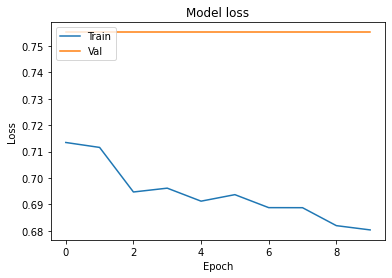

In [28]:
def plot_learningCurve(history, epoch):
  # Plot training & validation accuracy values
#   plt.plot(history.history['accuracy'])
#   plt.plot(history.history['val_accuracy'])
#   plt.title('Model accuracy')
#   plt.ylabel('Accuracy')
#   plt.xlabel('Epoch')
#   plt.legend(['Train', 'Val'], loc='upper left')
#   plt.show()

  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

plot_learningCurve(history, 20)

In [32]:
def medium_CNN(numclasses, input_shape):
    model = Sequential()
    model.add(Conv2D(16, (3,3), activation='relu', input_shape = input_shape))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2,2))
    model.add(Dropout(0.3))

    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2,2))
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2,2))
    model.add(Dropout(0.4))

    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2,2))
    model.add(Dropout(0.5))

    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))


    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))


    model.add(Dense(numclasses, activation='sigmoid'))
    return model

In [43]:
model_medium_CNN = medium_CNN(10, input_shape=(100, 100, 18))
callbacks_list = []

model_medium_CNN.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                          optimizer=keras.optimizers.Adam(),
                          metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')]) #TODO add callbacks to save checkpoints and maybe lr reducer, earlystop,etc 

epochs = 10
history = model_medium_CNN.fit(gen.training_dataset, validation_data=gen.validation_dataset, epochs=epochs)


Epoch 1/10
5/5 [==============================] - 86s 17s/step - loss: 0.9270 - accuracy: 0.1209 - val_loss: 0.8956 - val_accuracy: 0.1200
Epoch 2/10
5/5 [==============================] - 91s 19s/step - loss: 0.9144 - accuracy: 0.1223 - val_loss: 0.9091 - val_accuracy: 0.1200
Epoch 3/10
5/5 [==============================] - 85s 17s/step - loss: 0.9159 - accuracy: 0.1198 - val_loss: 0.9205 - val_accuracy: 0.1200
Epoch 4/10
5/5 [==============================] - 86s 18s/step - loss: 0.9162 - accuracy: 0.1193 - val_loss: 0.9494 - val_accuracy: 0.1200
Epoch 5/10
5/5 [==============================] - 84s 17s/step - loss: 0.9036 - accuracy: 0.1200 - val_loss: 0.9662 - val_accuracy: 0.1200
Epoch 6/10
5/5 [==============================] - 85s 17s/step - loss: 0.9077 - accuracy: 0.1201 - val_loss: 0.9763 - val_accuracy: 0.1200
Epoch 7/10
5/5 [==============================] - 89s 17s/step - loss: 0.9053 - accuracy: 0.1200 - val_loss: 0.9755 - val_accuracy: 0.1200
Epoch 8/10
5/5 [===========

In [44]:
predictions = model_medium_CNN.predict(np.array([img_test]))
highest_score_predictions = np.argmax(predictions) # TODO: read more about multi classes PER IMAGE classification, what is the threshold?

print("This chip was predicted to belong to top 3 classes:")

top3 = np.argsort(predictions[0])[:-4:-1]
for i in range(3):
  print(label_list[top3[i]])

This chip was predicted to belong to top 3 classes:
Water
Shifting_cultivation
Savannah


In [45]:
model_medium_CNN.evaluate(gen.validation_dataset)

3/3 [==============================] - 32s 11s/step - loss: 0.9204 - accuracy: 0.1200


[0.9204237461090088, 0.12000000476837158]

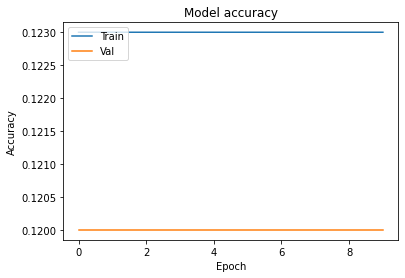

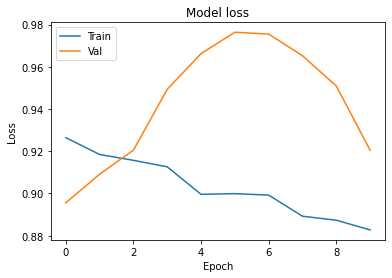

In [52]:
def plot_learningCurve(history, epoch):
  # Plot training & validation accuracy values
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

plot_learningCurve(history, 20)

TEST with bigearthnet-resnet50

In [14]:
import tensorflow_hub as hub
IMAGE_SIZE = (100,100)
num_classes = 10
model_handle = "https://tfhub.dev/google/remote_sensing/bigearthnet-resnet50/1"
model_bigearthnet = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    # reshape? 
    hub.KerasLayer(model_handle, trainable=False, input_shape=IMAGE_SIZE + (3,)),
#     (model.layers[-1].output)
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(num_classes,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model_bigearthnet.build((None,)+IMAGE_SIZE+(4,))
model_bigearthnet.summary()

ValueError: in user code:

    /usr/local/anaconda3/lib/python3.8/site-packages/tensorflow_hub/keras_layer.py:228 call  *
        result = f()
    /usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/eager/function.py:1669 __call__  **
        return self._call_impl(args, kwargs)
    /usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/eager/wrap_function.py:246 _call_impl
        return super(WrappedFunction, self)._call_impl(
    /usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/eager/function.py:1687 _call_impl
        return self._call_with_flat_signature(args, kwargs, cancellation_manager)
    /usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/eager/function.py:1736 _call_with_flat_signature
        return self._call_flat(args, self.captured_inputs, cancellation_manager)
    /usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/eager/function.py:1900 _call_flat
        raise ValueError(

    ValueError: The argument 'images' (value Tensor("Placeholder:0", shape=(None, 100, 100, 4), dtype=float32)) is not compatible with the shape this function was traced with. Expected shape (None, None, None, 3), but got shape (None, 100, 100, 4).
    
    If you called get_concrete_function, you may need to pass a tf.TensorSpec(..., shape=...) with a less specific shape, having None on axes which can vary.


In [23]:
# model_bigearthnet.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#           optimizer=keras.optimizers.Adam()) #TODO add callbacks to save checkpoints and maybe lr reducer, earlystop,etc 

# epochs = 10
# history = model_bigearthnet.fit(gen.training_dataset, validation_data=gen.validation_dataset, epochs=epochs)


In [ ]:
# predictions = model_resnet50.predict(np.array([img_test]))
# highest_score_predictions = np.argmax(predictions) # TODO: read more about multi classes PER IMAGE classification, what is the threshold?

# print("This chip was predicted to belong to class {}".format(label_list[highest_score_predictions]))

# Preproduction Candidate: ResNet50 pretrained on ImageNet

In [4]:
gen = DataLoader(label_file_path_train="labels_test_v1.csv", #or labels.csv
                        label_file_path_val="val_labels.csv",
                        bucket_name='canopy-production-ml',
                        data_extension_type='.tif',
                        training_data_shape=(100, 100, 18),
                        shuffle_and_repeat=False,
                        enable_just_shuffle=False,
                        enable_just_repeat=False,
                        training_data_shuffle_buffer_size=10,
                        data_repeat_count=None,
                        training_data_batch_size=20,
                        normalization_value=255.0,  #normalization TODO double check other channels than RGB 
                        training_data_type=tf.float32,
                        label_data_type=tf.uint8,
                        enable_data_prefetch=False,
                        data_prefetch_size=tf.data.experimental.AUTOTUNE,
                        num_parallel_calls=int(2))
# TODO add data augmentation in DataLoader 

no_of_val_imgs = len(gen.validation_filenames)
no_of_train_imgs = len(gen.training_filenames)
print("Validation on {} images ".format(str(no_of_val_imgs)))
print("Training on {} images ".format(str(no_of_train_imgs)))

NameError: name 'DataLoader' is not defined

In [5]:
def define_model(numclasses,input_shape):
    # parameters for CNN
    input_tensor = Input(shape=input_shape)

    # introduce a additional layer to get from bands to 3 input channels
    input_tensor = Conv2D(3, (1, 1))(input_tensor)

    base_model_resnet50 = keras.applications.ResNet50(include_top=False,
                              weights='imagenet',
                              input_shape=(100, 100, 3))
    base_model = keras.applications.ResNet50(include_top=False,
                     weights=None,
                     input_tensor=input_tensor)

    for i, layer in enumerate(base_model_resnet50.layers):
        # we must skip input layer, which has no weights
        if i == 0:
            continue
        base_model.layers[i+1].set_weights(layer.get_weights())

    # add a global spatial average pooling layer
    top_model = base_model.output
    top_model = GlobalAveragePooling2D()(top_model)

    # let's add a fully-connected layer
    top_model = Dense(2048, activation='relu')(top_model)
    top_model = Dense(2048, activation='relu')(top_model)
    # and a logistic layer
    predictions = Dense(numclasses, activation='softmax')(top_model)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

    model.summary()
    return model

In [7]:
random_id = 5555 #TODO
checkpoint_file = 'checkpoint_{}.h5'.format(random_id)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
  filepath= checkpoint_file,
  format='h5',
  verbose=1,
  save_weights_only=True,
  monitor='val_loss',
  mode='min',
  save_best_only=True)

reducelronplateau = tf.keras.callbacks.ReduceLROnPlateau(
  monitor='val_loss', factor=0.1, patience=10, verbose=1,
  mode='min', min_lr=1e-10)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='min', patience=20, verbose=1)

callbacks_list = [model_checkpoint_callback, reducelronplateau, early_stop]

model = define_model(10, (100,100,18))
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                          optimizer=keras.optimizers.Adam(),
                          metrics=[tf.metrics.BinaryAccuracy(name='accuracy')]) #TODO add callbacks to save checkpoints and maybe lr reducer, earlystop,etc 


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 18 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 100, 3)  57          input_1[0][0]                    
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 106, 106, 3)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 50, 50, 64)   9472        conv1_pad[0][0]                  
_______________________________________________________________________________________

In [8]:
epochs = 20
history = model.fit(gen.training_dataset, validation_data=gen.validation_dataset, 
                    epochs=epochs, 
                    callbacks=callbacks_list)


Epoch 1/20
      1/Unknown - 0s 0s/step - loss: 0.7377 - accuracy: 0.8900

KeyboardInterrupt: 

# Evaluation

In [16]:
model.evaluate(gen.validation_dataset) 

3/3 [==============================] - 9s 3s/step - loss: 0.6661 - accuracy: 0.9473


[0.6660677194595337, 0.9472727179527283]

# Sandbox

In [17]:
# Applying albumentations

In [21]:
help(gen.training_dataset)

Help on BatchDataset in module tensorflow.python.data.ops.dataset_ops object:

class BatchDataset(UnaryDataset)
 |  BatchDataset(input_dataset, batch_size, drop_remainder)
 |  
 |  A `Dataset` that batches contiguous elements from its input.
 |  
 |  Method resolution order:
 |      BatchDataset
 |      UnaryDataset
 |      DatasetV2
 |      collections.abc.Iterable
 |      tensorflow.python.training.tracking.base.Trackable
 |      tensorflow.python.framework.composite_tensor.CompositeTensor
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, input_dataset, batch_size, drop_remainder)
 |      See `Dataset.batch()` for details.
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  element_spec
 |      The type specification of an element of this dataset.
 |      
 |      >>> dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
 |      >>> dataset.element_spec
 |      TensorSpec(shape=(), 

In [24]:
# necessary imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
# import tensorflow_datasets as tfds
from functools import partial
from albumentations import (
    Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
    Rotate
)
AUTOTUNE = tf.data.experimental.AUTOTUNE

ModuleNotFoundError: No module named 'albumentations'

In [27]:
s3 = boto3.resource('s3')
# TODO test on entire test dataset
obj = s3.Object('canopy-production-ml', "chips/cloudfree-merge-polygons/split/test/100/100_1000_1000.tif")
obj_bytes = io.BytesIO(obj.get()['Body'].read())
with rasterio.open(obj_bytes) as src:
    img_test = np.transpose(src.read(), (1, 2, 0))
print(img_test.shape)

(100, 100, 18)


In [30]:
train_img = tf.image.convert_image_dtype(img_test,tf.float32)

In [34]:
train_img = tf.image.random_flip_left_right(train_img)

In [35]:
help(tf.image)

Help on package tensorflow._api.v2.image in tensorflow._api.v2:

NAME
    tensorflow._api.v2.image - Image ops.

DESCRIPTION
    The `tf.image` module contains various functions for image
    processing and decoding-encoding Ops.
    
    Many of the encoding/decoding functions are also available in the
    core `tf.io` module.
    
    ## Image processing
    
    ### Resizing
    
    The resizing Ops accept input images as tensors of several types. They always
    output resized images as float32 tensors.
    
    The convenience function `tf.image.resize` supports both 4-D
    and 3-D tensors as input and output.  4-D tensors are for batches of images,
    3-D tensors for individual images.
    
    Resized images will be distorted if their original aspect ratio is not the
    same as size. To avoid distortions see tf.image.resize_with_pad.
    
    *   `tf.image.resize`
    *   `tf.image.resize_with_pad`
    *   `tf.image.resize_with_crop_or_pad`
    
    The Class `tf.image.Resiz

## David's area

In [1]:
import boto3
import rasterio as rio
import numpy as np
import io
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
import keras

from data_loader import DataLoader

In [2]:
batch_size = 20
gen = DataLoader(label_file_path_train="labels_1_4_train_v2.csv",
                 label_file_path_val="val_labels.csv",
                 bucket_name='canopy-production-ml',
                 data_extension_type='.tif',
                 training_data_shape=(100, 100, 18),
                 augment=True,
                 random_flip_up_down=False, #Randomly flips an image vertically (upside down). With a 1 in 2 chance, outputs the contents of `image` flipped along the first dimension, which is `height`.
                 random_flip_left_right=False,
                 flip_left_right=True,
                 flip_up_down=True,
                 rot90=False,
                 transpose=False,
                 enable_shuffle=True,
                 # training_data_shuffle_buffer_size=10,
                 training_data_batch_size=batch_size,
                 training_data_type=tf.float32,
                 label_data_type=tf.uint8,
                 enable_data_prefetch=True,
                 data_prefetch_size=tf.data.experimental.AUTOTUNE,
                 num_parallel_calls=int(2))

Data augmentation enabled 
Training on 7886 images 
Validation on 366 images 
Your training file is missing positive labels for classes ['3']


In [3]:
gen.class_weight

{0: 2.7809829059829063,
 1: 0.6314895681707908,
 2: 1.1188480550182678,
 4: 0.6000461041954819,
 5: 1.9281481481481484,
 6: 1.6574339382362304,
 7: 1.2629791363415817,
 8: 0.8022807828633072,
 9: 0.7483110536150641}

In [4]:
def define_model(numclasses,input_shape):
    # parameters for CNN
    input_tensor = Input(shape=input_shape)

    # introduce a additional layer to get from bands to 3 input channels
    input_tensor = Conv2D(3, (1, 1))(input_tensor)

    base_model_resnet50 = keras.applications.ResNet50(include_top=False,
                              weights='imagenet',
                              input_shape=(100, 100, 3))
    base_model = keras.applications.ResNet50(include_top=False,
                     weights=None,
                     input_tensor=input_tensor)

    for i, layer in enumerate(base_model_resnet50.layers):
        # we must skip input layer, which has no weights
        if i == 0:
            continue
        base_model.layers[i+1].set_weights(layer.get_weights())

    # add a global spatial average pooling layer
    top_model = base_model.output
    top_model = GlobalAveragePooling2D()(top_model)

    # let's add a fully-connected layer
    top_model = Dense(2048, activation='relu')(top_model)
    top_model = Dense(2048, activation='relu')(top_model)
    # and a logistic layer
    predictions = Dense(numclasses, activation='softmax')(top_model)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

    model.summary()
    return model

In [7]:
import wandb
from wandb.keras import WandbCallback


wandb.init(project="canopy-first-model-testing", name="baseline")

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Currently logged in as: davidanagy (use `wandb login --relogin` to force relogin)
C:\Anaconda3\envs\canopy_test_models\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
wandb: wandb version 0.10.21 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [39]:
help(wandb.init)

Help on function init in module wandb.sdk.wandb_init:

init(job_type: Union[str, NoneType] = None, dir=None, config: Union[Dict, str, NoneType] = None, project: Union[str, NoneType] = None, entity: Union[str, NoneType] = None, reinit: bool = None, tags: Union[Sequence, NoneType] = None, group: Union[str, NoneType] = None, name: Union[str, NoneType] = None, notes: Union[str, NoneType] = None, magic: Union[dict, str, bool] = None, config_exclude_keys=None, config_include_keys=None, anonymous: Union[str, NoneType] = None, mode: Union[str, NoneType] = None, allow_val_change: Union[bool, NoneType] = None, resume: Union[bool, str, NoneType] = None, force: Union[bool, NoneType] = None, tensorboard=None, sync_tensorboard=None, monitor_gym=None, save_code=None, id=None, settings: Union[wandb.sdk.wandb_settings.Settings, Dict[str, Any], NoneType] = None) -> Union[wandb.sdk.wandb_run.Run, wandb.sdk.lib.disabled.RunDisabled, NoneType]
    Start a new tracked run with `wandb.init()`.
    
    In an

In [9]:
help(WandbCallback)

Help on class WandbCallback in module wandb.integration.keras.keras:

class WandbCallback(tensorflow.python.keras.callbacks.Callback)
 |  WandbCallback(monitor='val_loss', verbose=0, mode='auto', save_weights_only=False, log_weights=False, log_gradients=False, save_model=True, training_data=None, validation_data=None, labels=[], data_type=None, predictions=36, generator=None, input_type=None, output_type=None, log_evaluation=False, validation_steps=None, class_colors=None, log_batch_frequency=None, log_best_prefix='best_', save_graph=True)
 |  
 |  WandbCallback automatically integrates keras with wandb.
 |  
 |  Example:
 |      ```
 |      model.fit(X_train, y_train,  validation_data=(X_test, y_test),
 |          callbacks=[WandbCallback()])
 |      ```
 |  
 |  WandbCallback will automatically log history data from any
 |      metrics collected by keras: loss and anything passed into keras_model.compile() 
 |  
 |  WandbCallback will set summary metrics for the run associated with t

In [5]:
random_id = 5555 #TODO
checkpoint_file = 'checkpoint_{}.h5'.format(random_id)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
  filepath= checkpoint_file,
  format='h5',
  verbose=1,
  save_weights_only=True,
  monitor='val_loss',
  mode='min',
  save_best_only=True)

reducelronplateau = tf.keras.callbacks.ReduceLROnPlateau(
  monitor='val_loss', factor=0.1, patience=10, verbose=1,
  mode='min', min_lr=1e-10)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='min', patience=20, verbose=1)

#labels = ["Habitation", "ISL", "Industrial_agriculture", "Mining", "Rainforest",
#          "River", "Roads", "Savannah", "Shifting_cultivation", "Water"] # Cut out mining b/c not in training data

callbacks_list = [model_checkpoint_callback, reducelronplateau, early_stop]
                  #WandbCallback(monitor='accuracy', data_type="image", labels=labels)]

model = define_model(10, (100,100,18))
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                          optimizer=keras.optimizers.Adam(),
                          metrics=[tf.metrics.BinaryAccuracy(name='accuracy')]) #TODO add callbacks to save checkpoints and maybe lr reducer, earlystop,etc 


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 18 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 100, 3)  57          input_1[0][0]                    
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 106, 106, 3)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 50, 50, 64)   9472        conv1_pad[0][0]                  
_______________________________________________________________________________________

In [12]:
weights = gen.class_weight

corrected_weights = {}

for i in range(10):
    if i == 3:
        corrected_weights[i] = 1
    else:
        corrected_weights[i] = weights[i]
        
corrected_weights

{0: 2.7809829059829063,
 1: 0.6314895681707908,
 2: 1.1188480550182678,
 3: 1,
 4: 0.6000461041954819,
 5: 1.9281481481481484,
 6: 1.6574339382362304,
 7: 1.2629791363415817,
 8: 0.8022807828633072,
 9: 0.7483110536150641}

In [13]:
epochs = 20
history = model.fit(gen.training_dataset, validation_data=gen.validation_dataset, 
                    epochs=epochs, 
                    callbacks=callbacks_list,
                    class_weight=corrected_weights)

TypeError: '>' not supported between instances of 'NoneType' and 'int'

In [21]:
np.array(list(corrected_weights.values())).shape.rank

AttributeError: 'tuple' object has no attribute 'rank'

In [6]:
model = define_model(10, (100,100,18))

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 18 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 100, 3)  57          input_1[0][0]                    
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 106, 106, 3)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 50, 50, 64)   9472        conv1_pad[0][0]                  
_______________________________________________________________________________________

In [7]:
model.layers

In [8]:
model.layers[4]

In [9]:
bn = model.layers[4]

help(bn)

Help on BatchNormalization in module tensorflow.python.keras.layers.normalization_v2 object:

class BatchNormalization(tensorflow.python.keras.layers.normalization.BatchNormalizationBase)
 |  BatchNormalization(*args, **kwargs)
 |  
 |  Normalize and scale inputs or activations.
 |  
 |  Normalize the activations of the previous layer at each batch,
 |  i.e. applies a transformation that maintains the mean activation
 |  close to 0 and the activation standard deviation close to 1.
 |  
 |  Batch normalization differs from other layers in several key aspects:
 |  
 |  1) Adding BatchNormalization with `training=True` to a model causes the
 |  result of one example to depend on the contents of all other examples in a
 |  minibatch. Be careful when padding batches or masking examples, as these can
 |  change the minibatch statistics and affect other examples.
 |  
 |  2) Updates to the weights (moving statistics) are based on the forward pass
 |  of a model rather than the result of gradi

In [11]:
bn.name_scope()

'conv1_bn/'

In [12]:
bn.name

'conv1_bn'

In [13]:
model.layers[9].name

'conv2_block1_1_bn'

In [14]:
model.layers[2].name

'conv1_pad'

In [15]:
bns = []

for layer in model.layers:
    if 'bn' in layer.name:
        bns.append(layer)

In [16]:
bns

In [17]:
def define_model(numclasses, input_shape, freeze_bns=True):
    # parameters for CNN
    input_tensor = Input(shape=input_shape)

    # introduce a additional layer to get from bands to 3 input channels
    input_tensor = Conv2D(3, (1, 1))(input_tensor)

    base_model_resnet50 = keras.applications.ResNet50(include_top=False,
                              weights='imagenet',
                              input_shape=(100, 100, 3))
    base_model = keras.applications.ResNet50(include_top=False,
                     weights=None,
                     input_tensor=input_tensor)

    for i, layer in enumerate(base_model_resnet50.layers):
        # we must skip input layer, which has no weights
        if i == 0:
            continue
        base_model.layers[i+1].set_weights(layer.get_weights())
        
        if freeze_bns:
            if 'bn' in layer.name:
                base_model.layers[i+1].trainable = False

    # add a global spatial average pooling layer
    top_model = base_model.output
    top_model = GlobalAveragePooling2D()(top_model)

    # let's add a fully-connected layer
    top_model = Dense(2048, activation='relu')(top_model)
    top_model = Dense(2048, activation='relu')(top_model)
    # and a logistic layer
    predictions = Dense(numclasses, activation='softmax')(top_model)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

    model.summary()
    return model

In [18]:
model = define_model(10, (100,100,18))

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100, 100, 18 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 100, 100, 3)  57          input_3[0][0]                    
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 106, 106, 3)  0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 50, 50, 64)   9472        conv1_pad[0][0]                  
_______________________________________________________________________________________

In [19]:
model.layers[4].trainable

False

In [20]:
model.layers[3].trainable

True